# Imports

In [1]:
from sklearn.manifold import TSNE, MDS
from keras.models import load_model
from IPython.display import SVG, Audio, display
from keras.utils.vis_utils import model_to_dot
import numpy as np
import matplotlib.pyplot as plt
import librosa
%load_ext autoreload
%autoreload 2

/Users/sanmathikamath/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import sys
sys.path.append('../voicemap/')
sys.path.append('../')
from librispeech import LibriSpeechDataset
from utils import whiten, contrastive_loss
from config import LIBRISPEECH_SAMPLING_RATE
from voicemap.models import get_baseline_convolutional_encoder, build_siamese_net
from keras.optimizers import Adam

# Load and visualise pretrained model

In [3]:
#model_path = '../models/n_seconds/siamese__nseconds_3.0__filters_32__embed_64__drop_0.05__r_0.hdf5'
#model_path = '../models/siamese__filters_128__embed_64__drop_0.0__pad=True.hdf5'
#model_path = '../models_few_spkrs/siamese__filters_128__embed_64__drop_0.0__pad=True.hdf5'
model_path = '../all_models/model_e35/siamese__filters_128__embed_64__drop_0.0__pad=True.hdf5'
n_seconds = 3
downsampling = 4
batchsize = 64
filters = 128
embedding_dimension = 64
dropout = 0.0
input_length = int(LIBRISPEECH_SAMPLING_RATE * n_seconds / downsampling)


In [4]:
encoder = get_baseline_convolutional_encoder(filters, embedding_dimension, dropout=dropout)
siamese = build_siamese_net(encoder, (input_length, 1), distance_metric='uniform_euclidean')
opt = Adam(clipnorm=1.)
siamese.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
#siamese = load_model(model_path)
siamese.load_weights(model_path)

Instructions for updating:
Colocations handled automatically by placer.


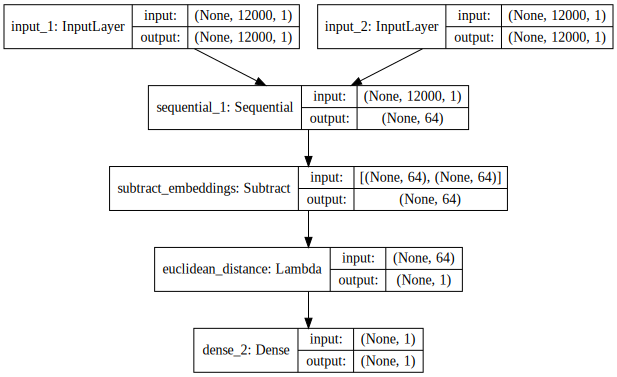

In [5]:
SVG(model_to_dot(siamese, show_shapes=True).create(prog='dot', format='svg'))

# Extract encoder
This extracts the encoder network that maps a single sample to a low dimensional space from the siamese network that takes two inputs.

In [6]:
from keras.models import Model
from keras.layers import Input

In [7]:
inputs = Input(shape=(12000,1))

encoded = siamese.layers[2](inputs)

In [8]:
encoder = Model(inputs=inputs, outputs=encoded)

In [9]:
encoder = siamese.layers[2]
encoder.compile(loss='mse',optimizer='adam')

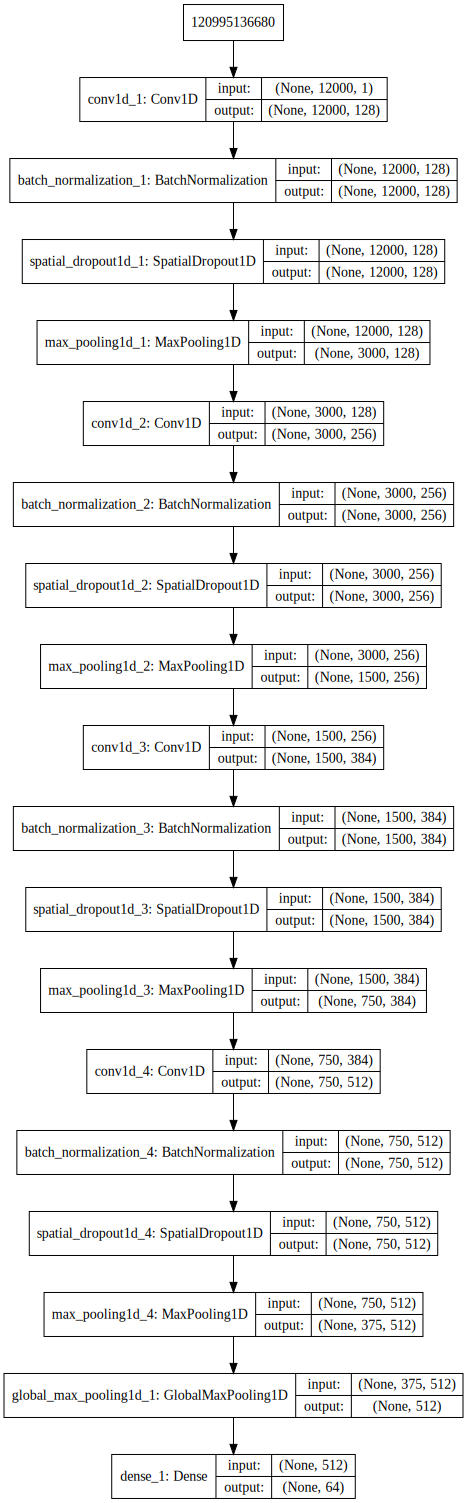

In [10]:
SVG(model_to_dot(encoder, show_shapes=True).create(prog='dot', format='svg'))

# Get data

In [11]:
def preprocessor(downsampling, whitening=True):
    def preprocessor_(batch):
        ([i_1, i_2], labels) = batch
        i_1 = i_1[:, ::downsampling, :]
        i_2 = i_2[:, ::downsampling, :]
        if whitening:
            i_1, i_2 = whiten(i_1), whiten(i_2)

        return [i_1, i_2], labels

    return preprocessor_


whiten_downsample = preprocessor(downsampling, whitening=True)

In [12]:
training_set = ['train-clean-100']
train = LibriSpeechDataset(training_set, 3, stochastic=False, pad=True)#, cache=False)
validation_set = ['dev-clean']
valid = LibriSpeechDataset(validation_set, 3, stochastic=False, pad=True)#,cache=False)
#train.build_n_shot_task(k=2,n=5)

Initialising LibriSpeechDataset with minimum length = 3s and subsets = ['train-clean-100']
Finished indexing data. 28442 usable files found.
Initialising LibriSpeechDataset with minimum length = 3s and subsets = ['dev-clean']
Finished indexing data. 2703 usable files found.


### Random samples from subset of speakers

In [24]:
n_speakers = 10
m_samples = 10
n_random_speakers = valid.df['speaker_id'].sample(n_speakers).values
#n_random_speakers=[6345, 7850, 7976, 8297]
#n_random_speakers=np.array([ 19,  26,  39,  40,  78,  83, 125, 150, 163, 196, 198, 200, 201, 211, 229, 233])

In [25]:
n_random_speakers.shape

(10,)

In [26]:
# Get m samples from each speaker
import pdb
def _get_m_samples_from_n_speakers(m_samples, n_random_speakers, valid):
    X, y, indexes = [], [], []
    for i in n_random_speakers:
        ids = valid.df[valid.df['speaker_id']==i]['id'].sample(m_samples).values
        #pdb.set_trace()
        Z = [train[i] for i in ids]
        X_ = np.stack(list(zip(*Z))[0])[:, :, np.newaxis]
        y_ = np.stack(list(zip(*Z))[1])[:, np.newaxis]
        [X_, _], _ = whiten_downsample(([X_, X_], []))

        X.append(X_)
        y.append(y_[:, 0])
        indexes.append(ids)
        #pdb.set_trace()
    X = np.concatenate(X)
    y = np.concatenate(y)
    indexes = np.concatenate(indexes)
    return X, y, indexes
X, y, indexes=_get_m_samples_from_n_speakers(m_samples, n_random_speakers, valid)

In [16]:
#print(X.shape, y[1], indexes[1])
#train.df[train.df['speaker_id']== 1001]
#n_random_speakers
#l=valid.df['speaker_id']
#print(l,l.values)

# Embed

In [27]:
embeddings = encoder.predict(X)
embeddings.shape

(100, 64)

In [17]:
from voicemap.utils import BatchPreProcessor, preprocess_instances, NShotEvaluationCallback
batchsize=64
batch_preprocessor = BatchPreProcessor('siamese', preprocess_instances(downsampling))
valid_generator = (batch_preprocessor(batch) for batch in valid.yield_verification_batches(batchsize))

In [18]:
y_pred=siamese.predict_generator(valid_generator, steps=1, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)

1/1 [==============================] - 9s 9s/step


In [20]:
#siamese.predict([X[0], X[1]], 1], batch_size=None, verbose=0, steps=None)

# Dimensionality Reduction

In [28]:
def compare_samples(a, b, write=False):
    sample_a = train[a]
    sample_b = train[b]

    print('Sample A ({}):'.format(a))
    display(Audio(data=sample_a[0],rate=LIBRISPEECH_SAMPLING_RATE))
    print('Sample B ({}):'.format(b))
    display(Audio(data=sample_b[0],rate=LIBRISPEECH_SAMPLING_RATE))
    if write:
        librosa.output.write_wav('audio_sample_A.wav', sample_a[0], LIBRISPEECH_SAMPLING_RATE )
        librosa.output.write_wav('audio_sample_B.wav', sample_b[0], LIBRISPEECH_SAMPLING_RATE )

In [29]:
tsne = TSNE(perplexity=30,learning_rate=1000, early_exaggeration=1, metric='cosine')

tsne_embeddings = tsne.fit_transform(embeddings)
tsne_embeddings.shape

(100, 2)

In [30]:
gender_markers = np.array([0 if train.df[train.df['id']==i]['sex'].values[0] == 'M' else 1 for i in indexes])

In [31]:
Z = np.hstack([tsne_embeddings, y[:, np.newaxis], gender_markers[:, np.newaxis]])
m = Z[Z[:, 3] == 0]
f = Z[Z[:, 3] == 1]
m.shape, f.shape

((29, 4), (71, 4))

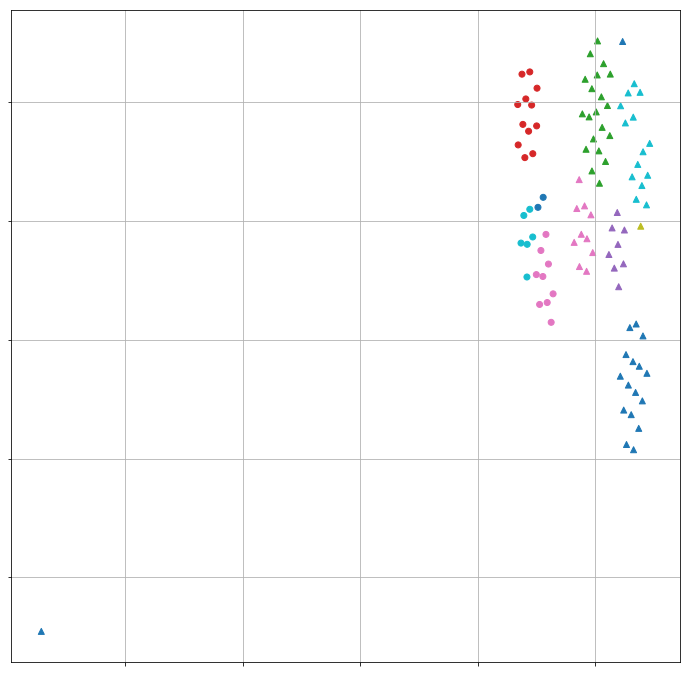

In [32]:
plt.figure(figsize=(12,12))

ax = plt.axes()
ax.scatter(m[:, 0], m[:, 1], c=[np.unique(m[:, 2]).tolist().index(i) for i in m[:, 2]], 
           marker='o', cmap='tab10')
ax.scatter(f[:, 0], f[:, 1], c=[np.unique(f[:, 2]).tolist().index(i) for i in f[:, 2]], 
           marker='^', cmap='tab10')

# Uncomment this block to show indexes of the samples in the dataset
#for x_, y_, idx, speaker_id in zip(Z[:, 0], Z[:, 1], indexes, y):
    #if np.random.random() < 0.025:
#   plt.text(x_, y_, idx)

ax.axes.set_xticklabels([])
ax.axes.set_yticklabels([])
plt.grid()
plt.show()

In [26]:
Z[:,2][0:5], indexes[0:5], y[0:5]

(array([40., 40., 40., 78., 40.]),
 array([693, 661, 708, 725, 699]),
 array([40, 40, 40, 78, 40]))

## Outliers/Misclassified

In [27]:
compare_samples(1487, 1594, write=True)

Sample A (1487):


Sample B (1594):


In [28]:
compare_samples(838, 2214, write=True) 

Sample A (838):


Sample B (2214):


# KNN Classifier 

In [33]:
from sklearn.neighbors import KNeighborsClassifier
n_speakers = 20
m_samples = 10
n_random_speakers = train.df['speaker_id'].sample(n_speakers).values
X_train, y_train, indexes=_get_m_samples_from_n_speakers(m_samples, n_random_speakers, train)
embeddings = encoder.predict(X_train)
embeddings.shape

(200, 64)

In [34]:
# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 1)
# Fit the classifier to the data
knn.fit(embeddings,y_train)
print(knn.score(embeddings, y_train))

1.0


In [36]:
##Testing
n_random_speakers = valid.df['speaker_id'].sample(n_speakers).values
X_valid, y_valid, indexes=_get_m_samples_from_n_speakers(m_samples, n_random_speakers, valid)
embeddings_valid = encoder.predict(X_valid)

In [37]:
y_pred=knn.predict(embeddings_valid)
print(knn.score(embeddings_valid, y_valid))

0.29


In [38]:
print(y_pred, y_valid)

[  39 8975 8975   39   39   39   39 8975   39 8975 8088 1594 8975 1081
 1594 8975 8088 8975 1594 8088 4640 4640   39 5339   39   39   39 5339
 4640 4640 8975 4640 6147   19 4640 6147 4640   19 4640 4640   39   39
   39   39   39   39   39   39   39   39 8088 8108   78 8108 8108 1081
 8108 1081 1081 8108 8108   89 8108 8468 8108 7226 8108 8108 8108 8108
   78 8468 8108 1081 8108 1081 1081 1081 1081 1081 6147   39 8975 6147
 8975 6147 8975 6147 6147 6147 8108 8108 4640 8108   89 8108 8108 8108
 8108 8108 7505 1081 7505 8975 7505 7505 7505 7505 7505 8975 8088 1081
 1081 1081 1594 1594 1594 8088 1081 8088 4640 4640   19 4640 3607 4640
 4640 4640 4640 4640  211  211  211  211   39   39  211  211  211  211
   78   78   78   78   78   78   78   78   78   78   19 8088   19   19
 8088 8088   19   19   19   19   89   89   89   89   89   89   89   89
 4640   89 7505 7505 7505 7505 1594 1594   89 1594 7505 1594   19   78
   78   78   78   19 4640   78   78   78   19   19 8088 8088   19   19
   19 

# DBSCAN

In [39]:

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics

In [40]:
db = DBSCAN(eps=2, min_samples=4)
y_pred=db.fit_predict(tsne_embeddings)

In [41]:
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
n_clusters_


0

In [33]:
labels

array([-1,  1,  1,  0,  1,  1,  1,  1,  1, -1,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  1,  1,  1,  0,  1,  1,  1,  1,  0,  0,  2,  2, -1,  2,
        2,  2,  2,  2,  2, -1,  2, -1,  3,  4, -1,  4,  4,  4,  4,  3,  2,
        2,  7,  7,  2, -1,  2,  2,  2,  2,  6,  6,  5, -1,  5,  5,  5,  6,
        5, -1, -1,  7,  7,  7,  7, -1, -1, -1, -1,  7,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  8,  8,  8, -1, -1, -1,  8,  8,  8,  8,  9,  9,
        9,  9, -1, 11, -1, -1, -1,  9, -1, -1, -1, -1, -1,  2, -1, -1, -1,
       -1, -1, -1,  2, -1,  2, -1, -1, -1,  2, -1, -1, -1,  3, -1,  3,  3,
       -1, -1, -1,  3,  0,  0, -1,  0,  0, -1, -1,  0,  0, 10, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       11, 11, 11, -1, 11, 11, 11, -1, 11, 11,  2,  2,  2,  2,  2,  2, -1,
        7,  7, -1,  0, 10,  0, -1, 10,  0,  0,  0, 10, 10])

In [67]:
y_pred2= db.labels_.astype(np.int)


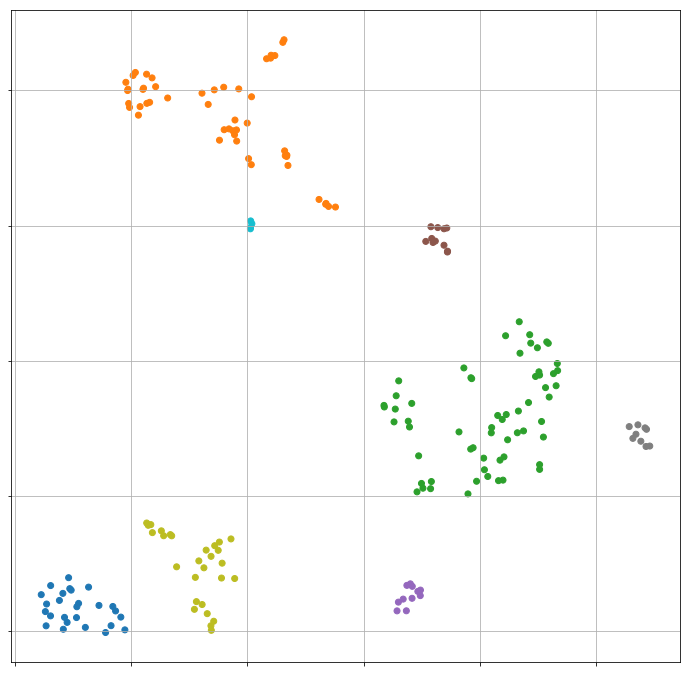

In [68]:
plt.figure(figsize=(12,12))

ax = plt.axes()
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:, 1], c=[np.unique(y_pred2).tolist().index(i) for i in y_pred2], 
           marker='o', cmap='tab10')

#Uncomment this block to show indexes of the samples in the dataset
#for x_, y_, idx, speaker_id in list(zip(Z[:, 0], Z[:, 1], indexes, y)):
    #if np.random.random() < 0.025:
    #plt.text(x_, y_, idx)
#centers = db.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
ax.axes.set_xticklabels([])
ax.axes.set_yticklabels([])
#ax.legend()
plt.grid()
plt.show()

# Accuracy

In [ ]:
from voicemap.utils import preprocess_instances,n_shot_task_evaluation, NShotEvaluationCallback, BatchPreProcessor

In [33]:
#ns=NShotEvaluationCallback(10, 1, 5, valid, batch_preprocessor)
n_task=100
n_shot=1
k_way=10
n_correct=n_shot_task_evaluation(siamese, valid, batch_preprocessor, n_task, n_shot, k_way, network_type='siamese', distance='euclidean')

100%|██████████| 100/100 [03:36<00:00,  1.92s/it]


In [34]:
acc=n_correct/n_task
acc

0.87

In [42]:
#ns=NShotEvaluationCallback(10, 1, 5, valid, batch_preprocessor)
n_task=100
n_shot=10 #Number of samples per class
k_way=30 #Number of classes in val
n_correct2=n_shot_task_evaluation(siamese, valid, batch_preprocessor, n_task, n_shot, k_way, network_type='siamese', distance='euclidean')

100%|██████████| 100/100 [1:43:33<00:00, 29.24s/it]  


In [43]:
acc2=n_correct2/n_task
acc2

0.81

In [41]:
y_pred2[0:5], Z[:,2][0:5], indexes[0:5], y[0:5]


(array([-1,  1,  1,  0,  1]),
 array([40., 40., 40., 78., 40.]),
 array([693, 661, 708, 725, 699]),
 array([40, 40, 40, 78, 40]))

In [42]:
c=[np.unique(Z[:, 2]).tolist().index(i) for i in Z[:, 2]]
y_pred

array([-1,  1,  1,  0,  1,  1,  1,  1,  1, -1,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  1,  1,  1,  0,  1,  1,  1,  1,  0,  0,  2,  2, -1,  2,
        2,  2,  2,  2,  2, -1,  2, -1,  3,  4, -1,  4,  4,  4,  4,  3,  2,
        2,  7,  7,  2, -1,  2,  2,  2,  2,  6,  6,  5, -1,  5,  5,  5,  6,
        5, -1, -1,  7,  7,  7,  7, -1, -1, -1, -1,  7,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  8,  8,  8, -1, -1, -1,  8,  8,  8,  8,  9,  9,
        9,  9, -1, 11, -1, -1, -1,  9, -1, -1, -1, -1, -1,  2, -1, -1, -1,
       -1, -1, -1,  2, -1,  2, -1, -1, -1,  2, -1, -1, -1,  3, -1,  3,  3,
       -1, -1, -1,  3,  0,  0, -1,  0,  0, -1, -1,  0,  0, 10, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       11, 11, 11, -1, 11, 11, 11, -1, 11, 11,  2,  2,  2,  2,  2,  2, -1,
        7,  7, -1,  0, 10,  0, -1, 10,  0,  0,  0, 10, 10])